In [7]:
#Set working directory
import os
os.chdir(r"C:\Users\dalila.rendon\Documents\data_ETL")

In [8]:
# importar paquetes
import pandas as pd
import numpy as np
import matplotlib
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

In [9]:
#esto es solo para comprobar que las instalaciones estaban en el venv ya que tuve problemas al principio
#print(os.getenv("JAVA_HOME"))
#print(os.getenv("SPARK_HOME"))

In [10]:
# create spark session
spark = SparkSession.builder.appName('tutorial pyspark').getOrCreate()

In [11]:
# nombrar los dos archivos de datos que se van a utilizar
PATH= "Recursos\\Infraestructura visible\\Etapa 1\\"
aeropuertos = spark.read.load(PATH+"aeropuertos.csv",format="csv", sep=",", inferSchema="true", header="true")
vuelos = spark.read.load(PATH+"vuelos.csv",format="csv", sep=",", inferSchema="true", header="true")

# Parte 1: informacion general

Acorde con las instrucciones, tenemos dos archivos para utilizar: aeropuertos.csv, y vuelos.csv. Es dificil entender lo que significan muchas de las categorias en estos archivos, y para esto es necesario el archivo diccionarios.xlsx. **nota**: yo ya habia resuelto la mayoria de los puntos antes de saber que diccionario.xlsx era tambien parte de lo que teniamos disponible, asi que las respuestas aca son asumiendo que no he visto el archivo diccionario.xlsx. 

In [54]:
# Para explorar el tipo de variables que hay en vuelos y aeropuertos, y saber cuales son numericas o categoricas
print(aeropuertos)
print(vuelos)

DataFrame[_c0: int, sigla: string, iata: string, nombre: string, municipio: string, departamento: string, categoria: string, latitud: double, longitud: double, propietario: string, explotador: string, longitud_pista: double, ancho_pista: double, pbmo: string, elevacion: double, resolucion: string, fecha_construccion: string, fecha_vigencia: string, clase: string, tipo: string, numero_vuelos_origen: string, gcd_departamento: int, gcd_municipio: int]
DataFrame[ano: int, mes: int, origen: string, destino: string, tipo_equipo: string, tipo_vuelo: string, trafico: string, empresa: string, vuelos: string, sillas: string, carga_ofrecida: double, pasajeros: string, carga_bordo: double]


# Parte 2: Perfilamiento de datos para cada analisis

## 1) Visualizar el número de pasajeros transportados en un rango de fechas de aeropuertos Internacionales a Colombia

**Nota**: aqui estoy asumiendo que cuando dicen "aeropuertos internacionales" se refieren a aeropuertos con categoria internacional, no a aeropuertos en el exterior. No hay informacion sobre vuelos provenientes del exterior hacia Colombia. 

Con respecto a un rango de fechas, estoy asumiendo que quieren el total dentro de un rango de fechas, y no el mes a mes en un rango de fechas seleccionado (lo cual tambien se podria hacer, pero se necesitarian otros comandos). Esto aplica para todos los analisis de aqui en adelante. 

In [12]:
# Filtrar archivo de aeropuertos para mostrar una columna con sigla y la categoria e ignorar la otra informacion (esto lo hago para que al momento de unir tablas no haya un monton de informacion irrelevante y sea mas facil visualizarlas)
aeropuertos_categorias_origen = aeropuertos.select(aeropuertos.sigla.alias("origen_sigla"), aeropuertos.categoria.alias("origen_categoria"))

aeropuertos_categorias_destino = aeropuertos.select(aeropuertos.sigla.alias("destino_sigla"), aeropuertos.categoria.alias("destino_categoria"))

# Unir la tabla de vuelos con aeropuertos utilizando la columna "sigla" como llave, e incluir nuevas columnas que indiquen si el origen y el destino son internacionales o no. El archivo de vuelos no indica si los vuelos son internacionales o no y por eso es necesario obtener esta informacion del archivo de aeropuertos. 
join_vuelos_aeropuertos = vuelos.join(aeropuertos_categorias_origen,vuelos.origen == aeropuertos_categorias_origen.origen_sigla, "inner") \
    .join(aeropuertos_categorias_destino,vuelos.destino == aeropuertos_categorias_destino.destino_sigla, "inner") 

# Exportar como .csv para utilizar en futuros analisis
join_vuelos_aeropuertos.toPandas().to_csv(PATH+'join_vuelos_aeropuertos.csv')

In [13]:
# Filtrar por aeropuertos origen internacional a aeropuertos destino no internacional (Colombia), en un rango de fechas solo del 2013 (puede ser cualquier otro ano o rango de fechas)
df_filter= join_vuelos_aeropuertos.where((join_vuelos_aeropuertos.origen_categoria == "Internacional")& (join_vuelos_aeropuertos.destino_categoria != "Internacional")&(join_vuelos_aeropuertos.ano == "2013")) 

In [14]:
#print(df_filter.schema)
#df_filter.show()
df_filter

DataFrame[ano: int, mes: int, origen: string, destino: string, tipo_equipo: string, tipo_vuelo: string, trafico: string, empresa: string, vuelos: string, sillas: string, carga_ofrecida: double, pasajeros: string, carga_bordo: double, origen_sigla: string, origen_categoria: string, destino_sigla: string, destino_categoria: string]

Al examinar la columna de pasajeros, vemos que es tipo "string", lo que sugiere que hay datos que no son numericos. Al mirar mas detalladamente, hay valores "nan", por lo que hay que eliminar estos valores, y luego transformar la variable a float

In [15]:
# contar valores "nan" y valores nulos
print(df_filter.select('pasajeros').where(df_filter.pasajeros == "nan").count())
print(df_filter.select('pasajeros').where(df_filter.pasajeros == "").count())
#df1.select(count(when(isnan(pasajeros))

534
0


No existen valores nulos (casillas en blanco), pero hay 534 nan (valoresno disponibles),que vamos a eliminar para el analisis. 

**Nota**: Hay varias maneras de lidiar con valores nulos y nan, por ejemplo reemplazarlos por el promedio, o asignarles valor "0". Si la distribucion es normal, reemplazar por promedio es una buena opcion, pero aqui calcular la distribucion de los datos implica analisis extras, y cuando estan sesgados el promedio no es un  buen representativo. De aqui en adelante optamos por eliminar los valores nulos de todos los analisis. 

In [16]:
# Eliminar "nan" y transformar "pasajeros" a float
df_pasajeros= df_filter.where(df_filter.pasajeros != 'nan') \
    .withColumn("pasajeros",df_filter["pasajeros"].cast(FloatType()))

#df_pasajeros.show()
df_pasajeros

DataFrame[ano: int, mes: int, origen: string, destino: string, tipo_equipo: string, tipo_vuelo: string, trafico: string, empresa: string, vuelos: string, sillas: string, carga_ofrecida: double, pasajeros: float, carga_bordo: double, origen_sigla: string, origen_categoria: string, destino_sigla: string, destino_categoria: string]

In [17]:
# mostrar numero de registros, promedio, mediana, deviacion standar, minima y maxima
df_pasajeros.select('pasajeros').summary().show()

+-------+------------------+
|summary|         pasajeros|
+-------+------------------+
|  count|              9490|
|   mean|  490.263751317176|
| stddev|1233.0732813720697|
|    min|               0.0|
|    25%|               2.0|
|    50%|              12.0|
|    75%|             252.0|
|    max|           11688.0|
+-------+------------------+



In [18]:
# calcular el numero total de pasajeros transportados
df_pasajeros.agg(functions.sum("pasajeros")).show()

+--------------+
|sum(pasajeros)|
+--------------+
|     4652603.0|
+--------------+



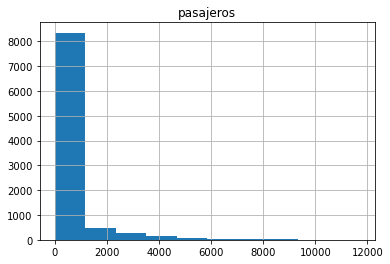

In [19]:
# Histograma de numero de pasajeros
# transformar a pandas
df_pasajeros_pd= df_pasajeros.toPandas()
df_pasajeros_pd.hist(column='pasajeros')
# exportar dataframe procesado como .csv
df_pasajeros_pd.to_csv(PATH+'pasajeros_procesada.csv')

# el codigo con pyspark no funciona ¯\_(ツ)_/¯
#histo_pasajeros = df1.select('pasajeros').rdd.flatMap(lambda x: x).histogram(10)
#print()

Para visualizar el numero de pasajeros por mes en el ano aqui seleccionado, se puede hacer aqui mismo con los paquetes instalados, o creando un tablero de control en Power BI con el archivo que se exporto "pasajeros_procesada.csv"

## 2) Visualizar la carga transportada en un rango de fechas de aeropuertos Internacionales a Colombia 

In [20]:
# contar valores "nan" y valores nulos
print(df_filter.select('carga_bordo').where(df_filter.carga_bordo == "nan").count())
print(df_filter.select('carga_bordo').where(df_filter.carga_bordo == "").count())
#df1.select(count(when(isnan(pasajeros))

0
0


En el caso de carga a bordo, no hay valores nulos ni nan. Segun se observa en un analisis anterior, la categoria "carga_bordo" es un double, entonces no hay necesidad de transformar a numerico. 

In [21]:
# mostrar numero de registros, promedio, mediana, deviacion standar, minima y maxima
df_filter.select('carga_bordo').summary().show()

+-------+-----------------+
|summary|      carga_bordo|
+-------+-----------------+
|  count|            10024|
|   mean|2719.570672386273|
| stddev|9502.228129945468|
|    min|              0.0|
|    25%|              0.0|
|    50%|            100.0|
|    75%|           1238.0|
|    max|         236306.0|
+-------+-----------------+



In [22]:
# calcular el numero total de carga transportada
df_filter.agg(functions.sum("carga_bordo")).show()

+----------------+
|sum(carga_bordo)|
+----------------+
|   2.726097642E7|
+----------------+



array([[<AxesSubplot:title={'center':'carga_bordo'}>]], dtype=object)

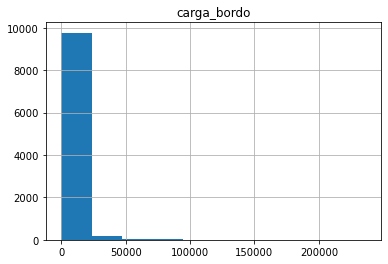

In [23]:
# Histograma de numero de carga a bordo
# transformar a pandas
df_filter_pd= df_filter.toPandas()
df_filter_pd.hist(column='carga_bordo')

De acuerdo con la tabla resumen y el histograma, es extrano que haya un dato extremo hacia la derecha (valor maximo), el cual es muy alto comparado con la mediana. Es posible que este sea un "outlier" correctamente registrado, o un error al momento de entrar los datos que toca revisar

## 3) Visualizar la carga desaprovechada en un rango de fechas de aeropuertos Internacionales a Colombia 

Anteriormente ya habiamos revisado que la categoria "carga_bordo" no tiene valores nulos ni nan, toca revisar lo mismo con "carga ofrecida" 

In [55]:
# contar valores "nan" y valores nulos
print(df_filter.select('carga_ofrecida').where(df_filter.carga_ofrecida == "nan").count())
print(df_filter.select('carga_ofrecida').where(df_filter.carga_ofrecida == "").count())

0
0


Hay que anadir un nuevo campo al dataframe que indique la carga desaprovechada, que seria carga_ofrecida - carga_bordo (ambas son valores tipo doubles)

In [24]:
# Eliminar valores nulos o nan
df_carga= df_filter.where((df_filter.carga_ofrecida != 'nan') & (df_filter.carga_bordo != 'nan'))

In [25]:
# anadir una nueva columna "carga_des"
df_carga= df_carga.withColumn("carga_des", df_carga.carga_ofrecida-df_carga.carga_bordo)

In [26]:
# Opcional: Eliminar los valores negativos (en los que la carga transportada fue mayor a la carga ofrecida)
#df_carga= df_carga.where((df_carga.carga_des > 0))

In [27]:
# mostrar numero de registros, promedio, mediana, deviacion standar, minima y maxima
df_carga.select('carga_des').summary().show()

+-------+------------------+
|summary|         carga_des|
+-------+------------------+
|  count|             10024|
|   mean|18054.661581205106|
| stddev| 58155.60203912821|
|    min|         -236306.0|
|    25%|            -100.0|
|    50%|               0.0|
|    75%|            7988.0|
|    max|         1081443.0|
+-------+------------------+



In [28]:
# calcular el numero total de carga desaprovechada
df_carga.agg(functions.sum("carga_des")).show()

+--------------------+
|      sum(carga_des)|
+--------------------+
|1.8097992768999997E8|
+--------------------+



array([[<AxesSubplot:title={'center':'carga_des'}>]], dtype=object)

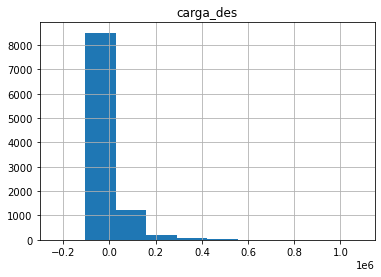

In [29]:
# Histograma de numero de carga desaprovechada
# transformar a pandas
df_carga_pd= df_carga.toPandas()
df_carga_pd.hist(column='carga_des')

En este caso se puede ver que hay ambos casos de carga desaprovechada (valores mayores a cero), y casos en los que la carga a bordo fue mayor que la oferta. Idealmente estos valores deberian ser cercanos a cero para que la oferta y la demanda sean similares, y valores muy altos son indeseables ya que hay demasiada oferta

## 4) Visualizar el número de puestos desaprovechados en un rango de fechas de aeropuertos Internacionales a Colombia 

Hay que anadir un nuevo campo al dataframe que indique los puestos desaprovechados, que seria sillas - pasajeros (ambas son valores tipo doubles)

In [30]:
# contar valores "nan" y valores nulos
print(df_filter.select('sillas').where(df_filter.sillas == "nan").count())
print(df_filter.select('sillas').where(df_filter.sillas == "").count())
print(df_filter.select('pasajeros').where(df_filter.pasajeros == "nan").count())
print(df_filter.select('pasajeros').where(df_filter.pasajeros == "").count())

591
0
534
0


Ya que los datos en sillas y pasajeros no estan completos y hay valores nulos, estos los vamos a eliminar del analisis

In [31]:
# Eliminar "nan" y transformar "pasajeros" y "sillas" a float
df_puestos= df_filter.where((df_filter.pasajeros != 'nan') & (df_filter.sillas != 'nan'))  \
    .withColumn("pasajeros",df_filter["pasajeros"].cast(FloatType())) \
    .withColumn("sillas",df_filter["sillas"].cast(FloatType()))  

In [32]:
#Examinar el tipo de variables y confirmar que las variables que originalmente eran "string" ahora sean numericas
df_puestos

DataFrame[ano: int, mes: int, origen: string, destino: string, tipo_equipo: string, tipo_vuelo: string, trafico: string, empresa: string, vuelos: string, sillas: float, carga_ofrecida: double, pasajeros: float, carga_bordo: double, origen_sigla: string, origen_categoria: string, destino_sigla: string, destino_categoria: string]

In [33]:
# anadir una nueva columna "puestos_des" que es la diferencia entre las sillas disponibles y el numero de pasajeros
df_puestos= df_puestos.withColumn("puestos_des", df_puestos.sillas-df_puestos.pasajeros)

In [34]:
#Opcional: Eliminar los valores negativos (en los que se sobrevendieron los puestos)
#df_puestos= df_puestos.where((df_puestos.puestos_des > 0))

In [35]:
# mostrar numero de registros, promedio, mediana, deviacion standar, minima y maxima
df_puestos.select('puestos_des').summary().show()

+-------+------------------+
|summary|       puestos_des|
+-------+------------------+
|  count|              9016|
|   mean|128.27118456078082|
| stddev| 408.8403629397313|
|    min|           -2135.0|
|    25%|              -6.0|
|    50%|              -1.0|
|    75%|              97.0|
|    max|            4805.0|
+-------+------------------+



In [36]:
# calcular el numero total de puestos desaprovechados
df_puestos.agg(functions.sum("puestos_des")).show()

+----------------+
|sum(puestos_des)|
+----------------+
|       1156493.0|
+----------------+



array([[<AxesSubplot:title={'center':'puestos_des'}>]], dtype=object)

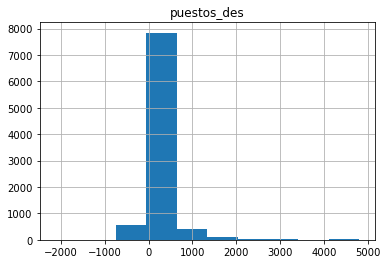

In [37]:
# Histograma de numero de puestos desaprovechados
# transformar a pandas
df_puestos_pd= df_puestos.toPandas()
df_puestos_pd.hist(column='puestos_des')

La presencia de numeros negativos indica vuelos sobrevendidos. La distribucion se ve relativamente normal, y el promedio de puestos desaprovechados idealmente deberia ser cercano a 0, pero en este caso es 128

## 5) Visualizar el porcentaje de cobertura Internacional, por rango de fechas, nacional o regional por departamentos de Colombia 

Esta indicacion es bastante ambigua, pero lo que yo entiendo es por cada departamento, incluyendo todos los tipos de aeropuertos en total, saber que porcentaje de vuelos dentro de cada departamento tienen destino con categoria internacional. No hay informacion acerca de vuelos al exterior. 

In [38]:
# Filtrar archivo de aeropuertos para mostrar una columna con sigla y el departamento e ignorar la otra informacion (esto lo hago para que al momento de unir tablas no haya un monton de informacion irrelevante y sea mas facil visualizarlas)

aeropuertos_departamento = aeropuertos.select(aeropuertos.sigla.alias("origen_sigla"), aeropuertos.departamento.alias("origen_departamento"))

# Unir la tabla de vuelos con aeropuertos utilizando la columna "sigla" como llave, e incluir nuevas columnas que indiquen el departamento de origen. El archivo de vuelos no indica si los vuelos son internacionales o no o el departamento, y por eso es necesario obtener esta informacion del archivo de aeropuertos. 
join_vuelos_aeropuertos = join_vuelos_aeropuertos.join(aeropuertos_departamento,join_vuelos_aeropuertos.origen == aeropuertos_departamento.origen_sigla, "inner") 

# Exportar como .csv para utilizar en futuros analisis
join_vuelos_aeropuertos.toPandas().to_csv(PATH+'join_vuelos_aeropuertos.csv')

In [39]:
# contar valores "nan" y valores nulos
print(join_vuelos_aeropuertos.select('vuelos').where(join_vuelos_aeropuertos.vuelos == "nan").count())
print(join_vuelos_aeropuertos.select('vuelos').where(join_vuelos_aeropuertos.vuelos == "").count())

6045
0


In [40]:
# Filtrar por rango de fechas (en este caso el ano 2013), excluir valores nulos en la variable "vuelos", y transformar a variable numerica (float)
# Agrupar por departamentos, y por categoria de destino. Mostrar el total de vuelos que hay de cada uno, y el porcentaje relativo al departamento

from pyspark.sql.window import Window

dept_int = join_vuelos_aeropuertos.where((join_vuelos_aeropuertos.ano == "2013") & (join_vuelos_aeropuertos.vuelos != "nan")) \
    .withColumn("vuelos",join_vuelos_aeropuertos["vuelos"].cast(FloatType())) \
    .groupBy(['origen_departamento','destino_categoria']).agg(functions.sum('vuelos').alias('vuelos_sum')) \
    .withColumn('porcentaje', 100.0*functions.col('vuelos_sum')/functions.sum('vuelos_sum').over(Window.partitionBy("origen_departamento"))).show()

+-------------------+-----------------+----------+------------------+
|origen_departamento|destino_categoria|vuelos_sum|        porcentaje|
+-------------------+-----------------+----------+------------------+
|       Cundinamarca|         Regional|     256.0| 20.38216560509554|
|       Cundinamarca|        Aeródromo|      59.0| 4.697452229299363|
|       Cundinamarca|    Internacional|     335.0|26.671974522292995|
|       Cundinamarca|         Nacional|     606.0|  48.2484076433121|
|          Antioquia|         Regional|      11.0| 3.654485049833887|
|          Antioquia|    Internacional|     137.0| 45.51495016611295|
|          Antioquia|         Nacional|     153.0| 50.83056478405316|
| Norte de Santander|        Aeródromo|     505.0| 0.559798694172551|
| Norte de Santander|    Internacional|   86284.0| 95.64687233264236|
| Norte de Santander|         Regional|    1873.0| 2.076243473634036|
| Norte de Santander|         Nacional|    1549.0|1.7170854995510525|
|          Santander

Aqui ya se indica el porcentaje de cada categoria de destino, y podria visualizarse en una torta. A primera vista es extrano ver que departamentos como Norte de Santander y Santander tengan una mayor cantidad de vuelos internacionales que por ejemplo Cundinamarca y Antioquia. Pero recordemos que en este analisis estamos asumiendo que vuelos internacionales significa un vuelo cuyo destino sea un aeropuerto de categoria "internacional". En este orden de ideas si tiene mas logica que vuelos provenientes de regiones pequenas tengan mas vuelos hacia aeopuertos internacionales. 

## 6) Visualizar el número de pasajeros transportados en un rango de fechas de aeropuertos Nacionales de Colombia 

Aqui asumimos que son pasajeros transportados **desde** aeropuertos nacionales, y no **hacia** aeropuertos nacionales 

In [41]:
# filtrar por rango de fechas (2013), y por categoria de aeropuerto nacional
pas_nac = join_vuelos_aeropuertos.where((join_vuelos_aeropuertos.ano == "2013") & (join_vuelos_aeropuertos.origen_categoria == "Nacional"))

In [58]:
# contar valores "nan" y valores nulos
print(pas_nac.select('pasajeros').where(pas_nac.pasajeros == "nan").count())
print(pas_nac.select('pasajeros').where(pas_nac.pasajeros == "").count())

0
0


Confirmamos que, al igual que la categoria de aeropuertos internacionales, los aeropuertos nacionales tampoco tienen datos faltantes o nulos

In [42]:
# Eliminar "nan" y transformar "pasajeros" a float
pas_nac= pas_nac.where(df_filter.pasajeros != 'nan') \
    .withColumn("pasajeros",df_filter["pasajeros"].cast(FloatType()))
# mostrar numero de registros, promedio, mediana, deviacion standar, minima y maxima
pas_nac.select('pasajeros').summary().show()

+-------+-----------------+
|summary|        pasajeros|
+-------+-----------------+
|  count|            16196|
|   mean|428.1609039268955|
| stddev|1139.374515057485|
|    min|              0.0|
|    25%|              2.0|
|    50%|              8.0|
|    75%|            166.0|
|    max|          12240.0|
+-------+-----------------+



In [43]:
# calcular el numero total de pasajeros transportados
pas_nac.agg(functions.sum("pasajeros")).show()

+--------------+
|sum(pasajeros)|
+--------------+
|     6934494.0|
+--------------+



array([[<AxesSubplot:title={'center':'pasajeros'}>]], dtype=object)

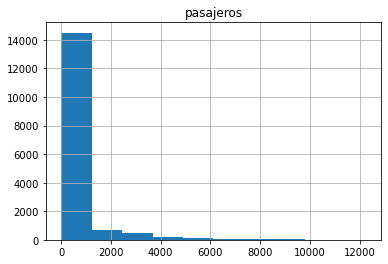

In [44]:
# Histograma de numero de pasajeros transportados
# transformar a pandas
pas_nac_pd= pas_nac.toPandas()
pas_nac_pd.hist(column='pasajeros')

## 7) Visualizar la carga transportada en un rango de fechas de aeropuertos Nacionales de Colombia

In [60]:
# filtrar por rango de fechas (2013), y por categoria de aeropuerto nacional origen
carga_nac = join_vuelos_aeropuertos.where((join_vuelos_aeropuertos.ano == "2013") & (join_vuelos_aeropuertos.origen_categoria == "Nacional"))

In [62]:
# contar valores "nan" y valores nulos
print(carga_nac.select('carga_bordo').where(carga_nac.carga_bordo == "nan").count())
print(carga_nac.select('carga_bordo').where(carga_nac.carga_bordo == "").count())

0
0


Anteriormente ya habiamos confirmado que la variable "carga_bordo" no tiene valores nulos ni nan, y es de tipo double, igual para aeropuertos internacionales y nacionales

In [46]:
# mostrar numero de registros, promedio, mediana, deviacion standar, minima y maxima
carga_nac.select('carga_bordo').summary().show()

+-------+------------------+
|summary|       carga_bordo|
+-------+------------------+
|  count|             17252|
|   mean|1302.8763725944802|
| stddev| 5179.983590089131|
|    min|               0.0|
|    25%|               0.0|
|    50%|              80.0|
|    75%|             679.0|
|    max|213202.08000000002|
+-------+------------------+



In [47]:
# calcular el numero total de carga a bordo
carga_nac.agg(functions.sum("carga_bordo")).show()

+--------------------+
|    sum(carga_bordo)|
+--------------------+
|2.2477223179999974E7|
+--------------------+



array([[<AxesSubplot:title={'center':'carga_bordo'}>]], dtype=object)

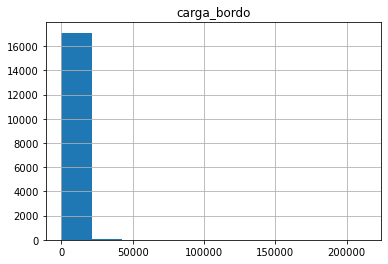

In [48]:
# Histograma de numero de carga a bordo
# transformar a pandas
carga_nac_pd= carga_nac.toPandas()
carga_nac_pd.hist(column='carga_bordo')

En este caso tambien es extrano ver valores "outliers" hacia la derecha, valores muy altos comparados con la media que estan sesgando la distribucion. Toca revisar si estos valores son correctos. 

## 8) Visualizar la cantidad de pasajeros salientes y entrantes a través del tiempo por departamentos de Colombia 

No existe informacion sobre pasajeros entrantes (estamos asumiendo que todos son salientes)

## 9) Visualizar la cantidad de carga aérea saliente y entrante a través del tiempo por departamentos de Colombia 

No existe informacion sobre carga entrante (se asume que toda es saliente)

## 10) Visualizar la relación entre las características de infraestructura de cada aeropuerto y el número de vuelos 

"infraestructura" es algo ambiguo, ya que puede representar diferentes caracteristicas de cada aeropuerto. En este caso como ejemplo vamos a tomar la longitud de la pista. 

In [49]:
# Lo primero es inspeccionar si los aeropuertos tienen mas de una longitud de pista, ya que es posible que hayan multiples pistas, y en este caso el analisis no podria hacerse. 
# Transformar longitud_pista de numerico a string
from pyspark.sql.types import StringType
aer_pista= aeropuertos.withColumn("longitud_pista",aeropuertos["longitud_pista"].cast(StringType())) \
    .select("sigla", "longitud_pista").distinct()
# Filtrar por aeropuertos que tengan mas de una categoria de longitud de pista
aer_pista.groupBy("sigla").agg(functions.count('sigla').alias('count')).where("count > 1").show()

+-----+-----+
|sigla|count|
+-----+-----+
|  CUC|    2|
+-----+-----+



En este caso se puede ver que el aeropuerto CUC tiene mas de una longitud de pista, por lo cual se excluira de futuros analisis. 

In [50]:
aer_pista = aer_pista.where((aer_pista.sigla != "CUC")) 
# tambien es posible hacerlo generico, donde no se excluye especificamente este aeropuerto, sino cualquier aeropuerto con mas de una longitud de pista

In [51]:
# Filtrar archivo de aeropuertos para mostrar una columna con sigla y la longitud de pista e ignorar la otra informacion (esto lo hago para que al momento de unir tablas no haya un monton de informacion irrelevante y sea mas facil visualizarlas)

aeropuertos_pista = aer_pista.select(aer_pista.sigla.alias("origen_sigla"), aer_pista.longitud_pista.alias("origen_pista"))

# Unir la tabla de vuelos con aeropuertos utilizando la columna "sigla" como llave, e incluir nuevas columnas que indiquen la longitud de la pista del aeropuerto de origen. El archivo de vuelos no indica las caracteristicas de infraestructura del aeropuerto de origen, y por eso es necesario obtener esta informacion del archivo de aeropuertos. 
join_vuelos_aeropuertos_pista = join_vuelos_aeropuertos.join(aeropuertos_pista,join_vuelos_aeropuertos.origen == aeropuertos_pista.origen_sigla, "inner") 

# Exportar como .csv para utilizar en futuros analisis
join_vuelos_aeropuertos_pista.toPandas().to_csv(PATH+'join_vuelos_aeropuertos_pista.csv')

In [52]:
# Eliminar valores nulos y nan de la categoria vuelos
# Ver los largos de pista y el numero de vuelos por aeropuerto

from pyspark.sql.window import Window

pista_aer = join_vuelos_aeropuertos_pista.where((join_vuelos_aeropuertos_pista.vuelos != "nan")) \
    .withColumn("vuelos",join_vuelos_aeropuertos_pista["vuelos"].cast(FloatType())) \
    .withColumn("origen_pista",join_vuelos_aeropuertos_pista["origen_pista"].cast(FloatType())) \
    .groupBy(['origen', 'origen_pista']).agg(functions.sum('vuelos').alias('vuelos_sum'))
pista_aer.show()


+------+------------+----------+
|origen|origen_pista|vuelos_sum|
+------+------------+----------+
|   A01|       450.0|      31.0|
|   BMG|       900.0|    4652.0|
|   PIP|      1700.0|     340.0|
|   MMP|      1175.0|     329.0|
|   9CE|       884.0|      17.0|
|   IGO|       840.0|       8.0|
|   9BW|      1200.0|      59.0|
|   SVI|      1500.0|    3389.0|
|   7NR|       550.0|       2.0|
|   7NT|      1200.0|    2450.0|
|   CLO|      3000.0|  186665.0|
|   7HG|      1000.0|     623.0|
|   9CG|       570.0|     504.0|
|   BOG|      3800.0| 2332396.0|
|   9AB|       800.0|     128.0|
|   9DI|      1100.0|      21.0|
|   ELB|      1225.0|     872.0|
|   9MW|      1000.0|       4.0|
|   PTL|      1500.0|    1363.0|
|   PTW|       850.0|      24.0|
+------+------------+----------+
only showing top 20 rows



Con esta tabla ya es posible visualizar a traves de una grafica "scatterdot" (por ejemplo en Power BI) si se ve alguna relacion entre el largo de la pista, y el numero de vuelos

# Parte 3: informacion adicional

**Supuestos**: el radio de cobertura es de 40Km. En caso de tener múltiples coberturas, se utiliza la jerarquía de categoría de cobertura para seleccionar la de mayor categoría. La jerarquía se entiende como Internacional es la de mayor categoría y cubre las demás categorías. En el caso de Nacional, incluye nacional, regional y local, en el caso de Regional solo cubre los vuelos regionales y locales. 

**Respuesta**: Para mi no es claro cual es la relacion entre la cobertura de 40 kms y los otros analisis que se preguntan